# 1.0 Introduction

**Goal:**
Predict the sales price for each house in the dataset.
Each ID in the test set must be accompanied by a SalePrice prediction.

**Evaluation Metric:**
Root-Mean-Squared-Error (RMSE) is the evaluation metric used for submissions.
Calculated between the log of the predicted value and the log of the observed sales price

**Output Format:**
File should contain a header with 'Id', and 'SalePrice' as a CSV format

# 2.0 Imports

## 2.1 Packages

In [33]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

## 2.2 Data Description

In [35]:
description = open('/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt', 'r')
if description.readable():
    print(description.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## 2.3 Loading Datasets

In [36]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")
print(f"Sample Shape: {sample.shape}")
print(f"ID Matches Between Test and Sample: {sample['Id'].equals(test['Id'])}")

Train Shape: (1460, 81)
Test Shape: (1459, 80)
Sample Shape: (1459, 2)
ID Matches Between Test and Sample: True


## 2.4 Dataset Inspection

Dataset is comprised of 1460 records and 81 columns with 79 feature columns 
(Excl. 'Id' and 'SalePrice')

In [37]:
features = [col for col in train.columns if col not in ['Id', 'SalePrice']]
target = ['SalePrice']

X_data = train[features]
Y_data = train['SalePrice']

In [38]:
X_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## 2.5 Identify Missing Values & Cardinality

Given that some features have over 90% of mssing values, removing these records will not be viable

In [39]:
from prettytable import PrettyTable

table = PrettyTable()

table.field_names = [
    'Column Name', 'Data Type', 'Non-Null Count', 'Missing Count', 'Unique', 
    'High Cardinality'
]

for column in X_data.columns:
    data_type = str(X_data[column].dtype)
    non_null_count = X_data[column].count()
    missing_count = X_data.shape[0] - non_null_count
    uniques = X_data[column].nunique()
    cardinality = uniques > 10
    table.add_row([column, data_type, non_null_count, missing_count, uniques, cardinality])
    
print(table)

+---------------+-----------+----------------+---------------+--------+------------------+
|  Column Name  | Data Type | Non-Null Count | Missing Count | Unique | High Cardinality |
+---------------+-----------+----------------+---------------+--------+------------------+
|   MSSubClass  |   int64   |      1460      |       0       |   15   |       True       |
|    MSZoning   |   object  |      1460      |       0       |   5    |      False       |
|  LotFrontage  |  float64  |      1201      |      259      |  110   |       True       |
|    LotArea    |   int64   |      1460      |       0       |  1073  |       True       |
|     Street    |   object  |      1460      |       0       |   2    |      False       |
|     Alley     |   object  |       91       |      1369     |   2    |      False       |
|    LotShape   |   object  |      1460      |       0       |   4    |      False       |
|  LandContour  |   object  |      1460      |       0       |   4    |      False       |

## 2.6 Feature Selection

Split features up into categorical ones (Object type), numerical (Int / Float), and discrete (< 20 uniques values)

In [41]:
# Selecting all categorical features (Object dtype)
cat_features = [col for col in X_data.columns if X_data[col].dtype == 'object']

# for col in cat_features:
#     print(col, X_data[col].nunique(), X_data[col].unique())

In [42]:
# Selecting all numerical features (int or float dtype) and nunique > 20
num_features = [col for col in X_data.columns if X_data[col].dtype in ['int64', 'float64'] and X_data[col].nunique() > 20]
# num_features

In [43]:
# Selection of discrete columns
discrete_features = [col for col in X_data.columns if X_data[col].nunique() < 20]

# for col in discrete_features:
#     print(col, X_data[col].nunique(), X_data[col].unique())

# 3.0 Handling Missing Values

Only 6.62% of the training dataset appears to be missing and 6.7% of testing data, so there is a likelihood that simply removing these samples will be suitable

## 3.1 Methods for Handling Missing Values

In [72]:
# Method to remove columns from a dataframe
def remove_columns(df, columns):
    X = df.copy()
    for col in columns:
        try:
            X.pop(col)
        except:
            pass
        
    return X

In [46]:
# Method for calculating the missing percentages from both test and train datasets
# given a list of features to include

def calc_missing_pct(train, test, features, show_all=False, display=False):
    # Calculate the missing percentages for both train and test data
    train_missing_pct = train[features].isnull().mean() * 100
    test_missing_pct = test[features].isnull().mean() * 100

    # Combine the missing percentages for train and test data into a single dataframe
    missing_pct_df = pd.concat([train_missing_pct, test_missing_pct], axis=1, keys=['Train%', 'Test%'])

    if not show_all:
        # Print the missing percentage dataframe (Excl. features without missing values)
        missing_features = missing_pct_df[(missing_pct_df['Train%'] > 0) | (missing_pct_df['Test%'] > 0)]
    else:
        missing_features = missing_pct_df
    
    if display:
        print(missing_features)
    
    return missing_features
    

In [54]:
# Calculate Mutual Information scores using full sets of X and Y data (Training only)
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import KNNImputer

def make_mi_scores(X, y):
    
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
        
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    cols = X.columns
    
    # KNN Imputer is used here to fill in some missing values before mutual_info_regression
    knn = KNNImputer(n_neighbors=2)
    X = knn.fit_transform(X, y)
    
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.DataFrame(mi_scores, columns=["MI Scores"], index=cols)
    mi_scores = mi_scores.sort_values(by="MI Scores", ascending=False)
    
    return mi_scores

# Calculate MI scores
mi_scores = make_mi_scores(X_data, Y_data)
mi_scores

,MI Scores
OverallQual,5.786503e-01
Neighborhood,5.253900e-01
GarageArea,4.927946e-01
GrLivArea,4.328080e-01
YearBuilt,4.087151e-01
...,...
Utilities,1.887379e-15
PoolArea,2.220446e-16
PoolQC,0.000000e+00
MiscVal,0.000000e+00


In [66]:
# Method for plitting MI scores and % of dataset missing to identify which columns with missing values can be dropped
import matplotlib.pyplot as plt
def plot_mi_scores(df):
    
    df = df.sort_values(by="MI Scores", ascending=True)
    
    # Set the width of the bars
    bar_width = 0.35
    
    scores = df['MI Scores']
    missing1 = df['Train%']
    missing2 = df['Test%']
    
    width = np.arange(len(df.index))
    ticks = list(scores.index)
    
    # Create a figure and axis
    fig, ax1 = plt.subplots()

    # Create horizontal bars for the first set of values
    bar1 = ax1.barh(width - bar_width/2, missing1, bar_width, label='Missing Pct Train', color='orange')
    
    # Create a twin axis for the second set of values
    ax2 = ax1.twiny()

    # Create horizontal bars for the second set of values
    bar2 = ax2.barh(width + bar_width/2, scores, bar_width, label='Scores')

    # Create horizontal bars for the second set of values
#     bar3 = ax2.barh(width + bar_width/2, missing2, bar_width, label='Missing Pct Test', color='yellow')
    
    # Set labels and title
    ax1.set_yticks(width)
    ax1.set_yticklabels(df.index)
    ax1.set_xlabel('Missing Pct')
    
    # Set labels for the secondary axis
    ax2.set_xlabel('Scores')
    
    plt.title("Mutual Information Scores")
    
    # Add a legend
    ax1.legend(loc='lower right')
    ax2.legend(loc='upper right')

    # Show the plot
    plt.show()

## 3.2 Analysis of Missing Values

In [55]:
# Loop to identify % of each dataset that is missing
for i, df in enumerate((train, test)):
    
    if i == 0:
        label = 'Train'
    else:
        label = 'Test'

    # get the number of missing data points per column
    missing_values_count = df.isnull().sum()

    # how many total missing values do we have?
    total_cells = np.product(df.shape)
    total_missing = missing_values_count.sum()

    # percent of data that is missing
    percent_missing = (total_missing/total_cells) * 100
    print(f"Percent of Missing Values in {label}: {percent_missing:.2f}%")

Percent of Missing Values in Train: 6.62%
Percent of Missing Values in Test: 6.75%


In [56]:
# Calculate the % missing per column per dataset and join with the MI scores dataframe
missing_data = calc_missing_pct(X_data, test, mi_scores.index, show_all=True)
concat_df = pd.concat([mi_scores, missing_data], axis=1).sort_values(by="MI Scores", ascending=False)
concat_df

,MI Scores,Train%,Test%
OverallQual,5.786503e-01,0.000000,0.00000
Neighborhood,5.253900e-01,0.000000,0.00000
GarageArea,4.927946e-01,0.000000,0.06854
GrLivArea,4.328080e-01,0.000000,0.00000
YearBuilt,4.087151e-01,0.000000,0.00000
...,...,...,...
Utilities,1.887379e-15,0.000000,0.13708
PoolArea,2.220446e-16,0.000000,0.00000
PoolQC,0.000000e+00,99.520548,99.79438
MiscVal,0.000000e+00,0.000000,0.00000


<Figure size 10000x6000 with 0 Axes>

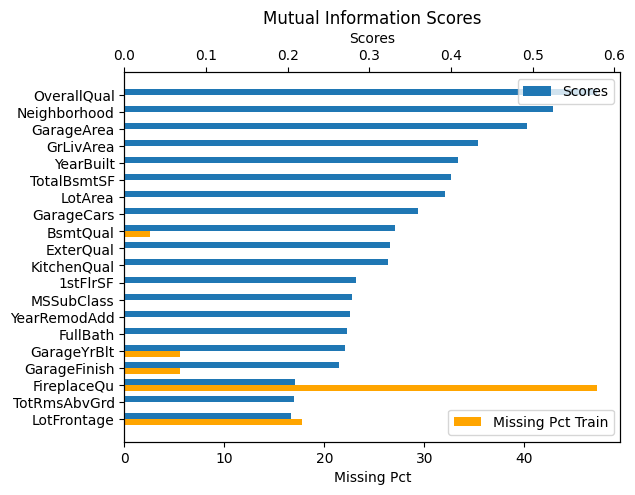

In [67]:
# Plot MI scores and % missing values on a horizontal bar chart
plt.figure(figsize=(100, 60))
plot_mi_scores(concat_df.head(20))

Its clear that columns that contain the highest MI scores do not have missing values, and those with high quantities of missing values have low scores, so these columns can simply be dropped wihtout affecting the model too much

## 3.1 Missing Categorical Features

Both train and test datasets have around the same missing values. For now, we can use some analysis and fill them

* Alley, MiscFeature, PoolQC are missing over 90% of values for both datasets -> Remove column
* Fence is missing > 80% for both datasets -> Remove column
* FireplaceQu, MasVnrType have roughly 50% missing -> Remove columns but be prepared to include later

In [68]:
missing_cat_features = calc_missing_pct(X_data, test, discrete_features, display=True)

                 Train%      Test%
MSZoning       0.000000   0.274160
Alley         93.767123  92.666210
Utilities      0.000000   0.137080
Exterior1st    0.000000   0.068540
Exterior2nd    0.000000   0.068540
MasVnrType    59.726027  61.274846
BsmtQual       2.534247   3.015764
BsmtCond       2.534247   3.084304
BsmtExposure   2.602740   3.015764
BsmtFinType1   2.534247   2.878684
BsmtFinType2   2.602740   2.878684
Electrical     0.068493   0.000000
BsmtFullBath   0.000000   0.137080
BsmtHalfBath   0.000000   0.137080
KitchenQual    0.000000   0.068540
Functional     0.000000   0.137080
FireplaceQu   47.260274  50.034270
GarageType     5.547945   5.209047
GarageFinish   5.547945   5.346127
GarageCars     0.000000   0.068540
GarageQual     5.547945   5.346127
GarageCond     5.547945   5.346127
PoolQC        99.520548  99.794380
Fence         80.753425  80.123372
MiscFeature   96.301370  96.504455
SaleType       0.000000   0.068540


In [69]:
# List of columns to remove after MI
cat_cols_to_remove = missing_cat_features[(missing_cat_features['Train%'] > 1) | (missing_cat_features['Test%'] > 1)].index.to_list()

# List of columns to perform imputation on
impute_cat_cols = missing_cat_features[(missing_cat_features['Train%'] < 1) | (missing_cat_features['Test%'] < 1)].index.to_list()

# Remaining slection of categorical columns with some values missing
calc_missing_pct(X_data, test, impute_cat_cols)

,Train%,Test%
MSZoning,0.000000,0.27416
Utilities,0.000000,0.13708
Exterior1st,0.000000,0.06854
Exterior2nd,0.000000,0.06854
Electrical,0.068493,0.00000
BsmtFullBath,0.000000,0.13708
BsmtHalfBath,0.000000,0.13708
KitchenQual,0.000000,0.06854
Functional,0.000000,0.13708
GarageCars,0.000000,0.06854


In [73]:
X_data_reduced = remove_columns(X_data, cat_cols_to_remove)

print("Remove columns 3 within temp dataframe 3: ", any(col in cat_cols_to_remove for col in X_data.columns))
print("Removed Columns: ", X_data.shape[1] - X_data_reduced.shape[1])

Remove columns 3 within temp dataframe 3:  True
Removed Columns:  15


## 3.2 Missing Numerical Features

There are slightly less numerical columns with missing features, and of those, only 3 are above 1%. We will remove these from the dataset

In [71]:
missing_cat_features = calc_missing_pct(X_data, test, num_features, display=True)

                Train%      Test%
LotFrontage  17.739726  15.558602
MasVnrArea    0.547945   1.028101
BsmtFinSF1    0.000000   0.068540
BsmtFinSF2    0.000000   0.068540
BsmtUnfSF     0.000000   0.068540
TotalBsmtSF   0.000000   0.068540
GarageYrBlt   5.547945   5.346127
GarageArea    0.000000   0.068540


In [74]:
# List of numerical columns to remove if % missing threshold is above 1%
remove_num_cols_1 = missing_cat_features[(missing_cat_features['Train%'] > 1) | (missing_cat_features['Test%'] > 1)].index.to_list()

X_data_reduced = remove_columns(X_data_reduced, remove_num_cols_1)
print("Remove num columns 1 within temp dataframe 4: ", any(col in remove_num_cols_1 for col in X_data_rem_cols_4.columns))
print("Removed Columns: ", X_data.shape[1] - X_data_rem_cols_4.shape[1])



Remove num columns 1 within temp dataframe 4:  False
Removed Columns:  18


# 4.0 Model Development

## 4.1 Data Preparation

Modified X_data will be split into training and validation sets before entering the model

In [77]:
from sklearn.model_selection import train_test_split

# Split training dataset into training and validation
X_train, X_valid, Y_train, Y_valid = train_test_split(X_data_reduced, Y_data, test_size=0.2, random_state=2)

print("New shapes for datasets:")
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

New shapes for datasets:


((1168, 61), (292, 61), (1168,), (292,))

In [81]:
# Define new categorical and numerical column lists for the pipeline

# Re-define new numerical features list
new_num_features = [col for col in X_data_reduced.columns if X_data_reduced[col].dtype in ['int64', 'float64'] and X_data_reduced[col].nunique() > 20]

# Re-define new categorical features list
impute_cat_cols = [col for col in X_data_rem_cols_4.columns if X_data_rem_cols_4[col].nunique() < 20]

# Check to ensure there are no columns missing
[element for element in new_num_features if element not in X_train.columns]
[element for element in impute_cat_cols if element not in X_train.columns]

[]

## 4.2 Model Selection

In [82]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from sklearn.impute import KNNImputer


# Preprocessing for numerical data
numerical_transformer = KNNImputer(n_neighbors=2)


# Preprocessing for categorical data
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
) 


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, new_num_features),
        ('cat', categorical_transformer, impute_cat_cols)
    ]
)

# Define a model
# model = RandomForestRegressor(n_estimators=100, random_state=0, criterion=“squared_error”, n_jobs=4)
# model = GradientBoostingRegressor(max_depth = 6, learning_rate=0.05, criterion='squared_error', random_state=2)
model = XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=4, random_state=2)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, Y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(Y_valid, preds)
print(f'MAE: {score:.2f}')


MAE: 18413.20


Random Forest Regressor MAE: 20604.526056751467

Gradient Boosting Regressor MAE: 20192.01

XGBoost MAE: 18413.20 <- Best performing regressor

In [83]:
# Preprocessing of validation data, get predictions
sub_preds = my_pipeline.predict(test[X_data_rem_cols_4.columns])

# Submission
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': sub_preds
})

submission.to_csv('/kaggle/working/submission.csv', index=False)

submission.head()

,Id,SalePrice
0,1461,117861.351562
1,1462,154675.718750
2,1463,196425.062500
3,1464,194589.406250
4,1465,179002.484375
